In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm  
from helpers import load_dataset_paths, load_vep_csv, summarize_results_and_save
import pywt
from featex import FeatureExtractor
from CNN_classifier import MultiBranchCNN
from CNN_classifier import MultiBranchCNN, AttentionLayer, TemporalAttention

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Loading Preprocessed Files and Metadata

In [2]:
all_paths = load_dataset_paths()

# Example usage:
prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")

from scipy.stats import pearsonr

# --- Load the per-category summary tables ---
snr_summary_BC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_Only/SNR_summary_BC_Only.csv")
snr_summary_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/RGC_Only/SNR_summary_RGC_Only.csv")
snr_summary_BC_and_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_and_RGC/SNR_summary_BC_and_RGC.csv")

# --- Compute SNR ratio ---
for df in [snr_summary_BC, snr_summary_RGC, snr_summary_BC_and_RGC]:
    df["SNR_Ratio"] = df["SNR_Signal"] / df["SNR_Noise"]
    df["FileName"] = df["FileName"].str.strip()

# --- IQR-based outlier removal ---
def filter_by_iqr(df, label):
    q1, q3 = df["SNR_Ratio"].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    filtered = df[(df["SNR_Ratio"] >= lower) & (df["SNR_Ratio"] <= upper)].copy()

    n_removed = len(df) - len(filtered)
    mean_ratio, std_ratio = filtered["SNR_Ratio"].mean(), filtered["SNR_Ratio"].std()
    print(f"[{label}] kept {len(filtered):3d}/{len(df):3d} files  "
          f"({len(filtered)/len(df)*100:5.1f}% kept, {n_removed} removed)  "
          f"→ mean SNR ratio = {mean_ratio:6.2f} ± {std_ratio:6.2f}")
    return filtered

filtered_BC = filter_by_iqr(snr_summary_BC, "BC_Only")
filtered_RGC = filter_by_iqr(snr_summary_RGC, "RGC_Only")
filtered_BC_and_RGC = filter_by_iqr(snr_summary_BC_and_RGC, "BC_and_RGC")

# --- Match filenames back to actual file paths ---
def match_filtered_files(file_list, filtered_df, label):
    def normalize_name(name):
        base = os.path.basename(str(name)).strip().lower()
        if not base.endswith(".csv"):
            base += ".csv"
        return base

    filtered_names = [normalize_name(n) for n in filtered_df["FileName"]]
    file_map = {normalize_name(f): f for f in file_list}
    matched = [file_map[n] for n in filtered_names if n in file_map]
    skipped = [n for n in filtered_names if n not in file_map]
    print(f"[{label}] matched {len(matched)}/{len(filtered_names)} files ({len(skipped)} skipped)")
    if skipped:
        print("⚠️ Skipped (not matched):", ", ".join(skipped[:8]), "..." if len(skipped) > 8 else "")
    return matched

prima_files_BC_only = match_filtered_files(prima_files_BC_only, filtered_BC, "BC_Only")
prima_files_RGC_only = match_filtered_files(prima_files_RGC_only, filtered_RGC, "RGC_Only")
prima_files_BC_and_RGC = match_filtered_files(prima_files_BC_and_RGC, filtered_BC_and_RGC, "BC_and_RGC")

# --- Template correlation filter ---
def template_correlation_filter(file_list, label, corr_thresh=0.3, t_min=10, t_max=200):
    """
    Keep only signals whose waveform correlates positively with the class average template.
    """
    if len(file_list) == 0:
        print(f"[{label}] no files to process.")
        return []

    # Load all signals
    all_signals = []
    for f in file_list:
        try:
            _, sig = load_vep_csv(f, t_min=t_min, t_max=t_max, normalize=True)
            all_signals.append(sig)
        except Exception as e:
            print(f"⚠️ Skipped {f}: {e}")

    if len(all_signals) == 0:
        print(f"[{label}] no valid signals loaded.")
        return []

    # Align lengths
    min_len = min(len(s) for s in all_signals)
    signals = np.array([s[:min_len] for s in all_signals])
    template = np.mean(signals, axis=0)

    # Compute correlation for each signal
    corrs = [pearsonr(sig, template)[0] for sig in signals]
    keep_mask = np.array(corrs) >= corr_thresh

    kept = np.array(file_list)[keep_mask].tolist()
    removed = np.array(file_list)[~keep_mask].tolist()
    print(f"[{label}] kept {len(kept):3d}/{len(file_list):3d} after template correlation filter "
          f"(corr ≥ {corr_thresh})")

    return kept

# --- Apply template correlation filtering ---
prima_files_BC_only = template_correlation_filter(prima_files_BC_only, "BC_Only")
prima_files_RGC_only = template_correlation_filter(prima_files_RGC_only, "RGC_Only")
prima_files_BC_and_RGC = template_correlation_filter(prima_files_BC_and_RGC, "BC_and_RGC")

print("\nAfter IQR + correlation filtering:")
print(f"  BC_Only:     {len(prima_files_BC_only)} files")
print(f"  RGC_Only:    {len(prima_files_RGC_only)} files")
print(f"  BC_and_RGC:  {len(prima_files_BC_and_RGC)} files")

PRIMA BC_Only files: 138
PRIMA RGC_Only files: 67
PRIMA BC_and_RGC files: 32
[BC_Only] kept 125/137 files  ( 91.2% kept, 12 removed)  → mean SNR ratio =   2.05 ±   1.01
[RGC_Only] kept  60/ 66 files  ( 90.9% kept, 6 removed)  → mean SNR ratio =   1.62 ±   0.93
[BC_and_RGC] kept  29/ 31 files  ( 93.5% kept, 2 removed)  → mean SNR ratio =   5.28 ±   2.72
[BC_Only] matched 125/125 files (0 skipped)
[RGC_Only] matched 60/60 files (0 skipped)
[BC_and_RGC] matched 29/29 files (0 skipped)
[BC_Only] kept 101/125 after template correlation filter (corr ≥ 0.3)
[RGC_Only] kept  42/ 60 after template correlation filter (corr ≥ 0.3)
[BC_and_RGC] kept  29/ 29 after template correlation filter (corr ≥ 0.3)

After IQR + correlation filtering:
  BC_Only:     101 files
  RGC_Only:    42 files
  BC_and_RGC:  29 files


## 2. Feature extraction

### Multichannel DWT

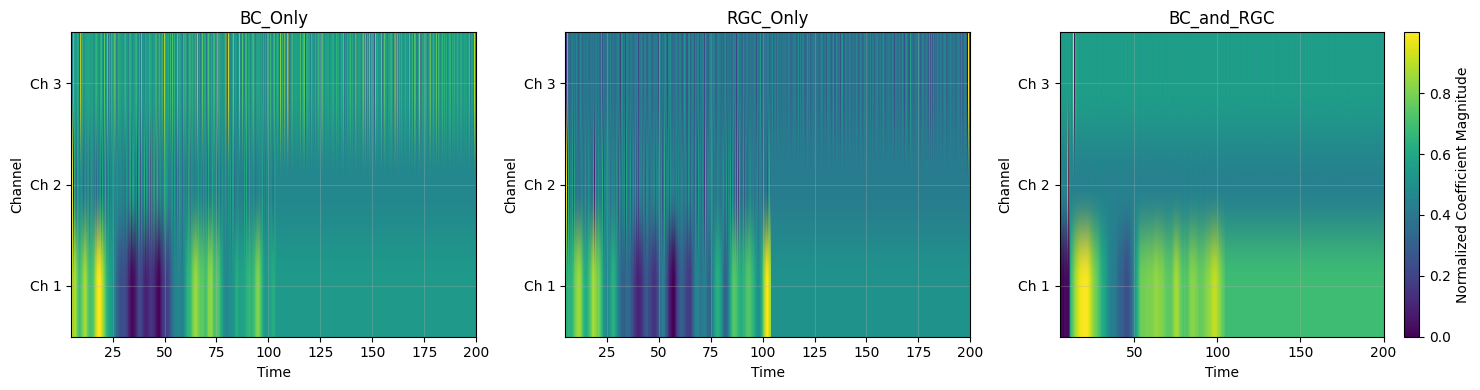

In [3]:
featex = FeatureExtractor()
dwt_data = {}

# --- Compute CWT scalograms ---
for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
    file_list = prima_files_BC_only if label == "BC_Only" else \
                prima_files_RGC_only if label == "RGC_Only" else \
                prima_files_BC_and_RGC

    for file in file_list:
        time, signal = load_vep_csv(file, t_min=5, t_max=200, normalize=True)

        features = featex.extract_dwt_features_multi_channel(signal, level=2, wavelet='db4')
        dwt_data[file] = {"features": features, "label": label}

unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
plt.figure(figsize=(15, 4))

for i, label in enumerate(unique_labels, 1):
    plt.subplot(1, 3, i)
    
    # Pick 1 example from this class
    example_files = [f for f in dwt_data if dwt_data[f]["label"] == label][:1]
    file = example_files[0]
    data = dwt_data[file]["features"]    
    channels, time_points = data.shape
    data_viz = np.array([(ch - ch.min()) / (ch.max() - ch.min() + 1e-8) for ch in data])
    plt.imshow(data_viz, aspect='auto', extent=[time[0], time[-1], 0, channels], cmap='viridis', origin='lower')
    #plt.imshow(data, aspect='auto', extent=[time[0], time[-1], 0, channels], cmap='viridis', origin='lower')
    plt.title(f"{label}")
    plt.xlabel("Time")
    #plt.yticks(np.arange(channels)+0.5, ['A4', 'D4', 'D3', 'D2', 'D1'])
    plt.yticks(np.arange(channels)+0.5, [f"Ch {i+1}" for i in range(channels)])
    plt.ylabel("Channel")
    plt.grid(alpha=0.3)
plt.colorbar(label='Normalized Coefficient Magnitude')
plt.tight_layout()
plt.show()

# D1 highest Detail, A4 lowest Approximation

### WPD

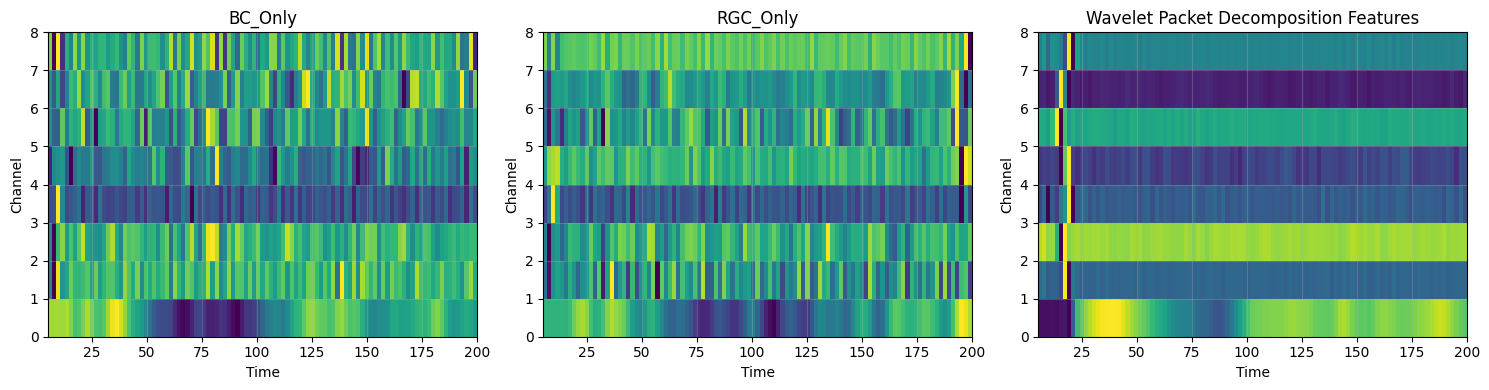

In [4]:
featex = FeatureExtractor()
wpd_data = {}

# --- Compute CWT scalograms ---
for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
    file_list = prima_files_BC_only if label == "BC_Only" else \
                prima_files_RGC_only if label == "RGC_Only" else \
                prima_files_BC_and_RGC

    for file in file_list:
        time, signal = load_vep_csv(file, t_min=5, t_max=200, normalize=True)

        features, _ = featex.extract_wpd_features(signal, level=3, wavelet='db4')
        wpd_data[file] = {"features": features, "label": label}

unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
plt.figure(figsize=(15, 4))

for i, label in enumerate(unique_labels, 1):
    plt.subplot(1, 3, i)
    
    # Pick 1 example from this class
    example_files = [f for f in wpd_data if wpd_data[f]["label"] == label][:1]
    file = example_files[0]
    data = wpd_data[file]["features"]    
    channels, time_points = data.shape
    #plt.imshow(data, aspect='auto', extent=[0, 1, 0, channels], cmap='viridis', origin='lower')
    data_viz = np.array([(ch - ch.min()) / (ch.max() - ch.min() + 1e-8) for ch in data])
    plt.imshow(data_viz, aspect='auto', extent=[time[0], time[-1], 0, channels], cmap='viridis', origin='lower')
    plt.title(f"{label}")
    plt.xlabel("Time")
    plt.ylabel("Channel")
    plt.grid(alpha=0.3)
plt.title("Wavelet Packet Decomposition Features")
plt.tight_layout()
plt.show()

## Classification

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from CNN_classifier import AttentionLayer
from tensorflow.keras import models

average_results = {}

signal_types = ["WPD"]

n_experiments = 1

all_conf_matrices = []
results = []
np.random.seed(42)
for signal_type in signal_types:
    print(f"=== Signal Type: {signal_type} ===")
    for experiments in range(n_experiments):
        print(f"--- Experiment {experiments + 1} ---")
        no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
        sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
        sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
        sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

        X, labels = [], []
        feature_list = []
        for label, file_list in zip(
            ["BC_Only", "RGC_Only", "BC_and_RGC"],
            [sampled_BC, sampled_RGC, sampled_BC_and_RGC]):
            for file in file_list:
                _, signal = load_vep_csv(file, t_min=5, t_max=200, normalize=True)
                if signal_type == "DWT":
                    features = featex.extract_dwt_features_multi_channel(signal, wavelet='db4', level=4)
                elif signal_type == "WPD":
                    features, node_paths = featex.extract_wpd_features(signal, wavelet='db4', level=4)
                    #print("Raw WPD shape:", features.shape)
                feature_list.append(features)
                labels.append(label)

        label_encoder = {'BC_Only': 0, 'RGC_Only': 1, 'BC_and_RGC': 2}
        label_decoder = {v: k for k, v in label_encoder.items()}
        X = np.stack([features for features in feature_list]) 
        #print("Feature shapes:")
        #print([feat.shape for feat in X])
        X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-8)


        n_train = len(X)
        print(f"Training samples: {n_train}")

        batch_size = max(4, min(32, n_train // 10))

        print(f"Using batch size: {batch_size}")
        if n_train < 100:
            epochs = 50
        elif n_train < 500:
            epochs = 35
        else:
            epochs = 20
        print(f"Using epochs: {epochs}")
        # batch_size = 5
        # epochs = 40
        n_splits = 5
        print(f"Number of training samples: {n_train}, epochs: {epochs}, batch size: {batch_size}")

        y = np.array([label_encoder[l] for l in labels])
        time_len = X.shape[2]
        n_branches = X.shape[1]
        clf = MultiBranchCNN(input_shape=(time_len, 1), n_branches=n_branches, n_classes=3)
        y_true, y_pred, _ = clf.fit(X, y, n_splits=n_splits, epochs=epochs, batch_size=batch_size)
        metrics = clf.evaluate(y_true, y_pred, label_encoder, label_decoder)
        print(metrics)

        results.append({
                "Accuracy": metrics["accuracy"],
                "BalancedAcc": metrics["balanced_accuracy"],
                "F1": metrics["f1_score"],
                "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
                "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
                "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
            })
        y_true_labels = [label_decoder[i] for i in y_true]
        y_pred_labels = [label_decoder[i] for i in y_pred]
        all_conf_matrices.append(
            confusion_matrix(
                y_true_labels, y_pred_labels, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
            )
        )
        # -------------------------
        #  Extract Attention Weights (subband attention)
        # -------------------------
        # 1) Get trained attention layer and merged output
        trained_att_layer = clf.model.get_layer("subband_attention")
        merged_output = clf.model.get_layer("merged_subbands").output

        att_clone = AttentionLayer(return_attention=True, name="att_clone")
        _ = att_clone(merged_output)  # build it
        att_clone.set_weights(trained_att_layer.get_weights())

        # Model for subband attention
        _, subband_att_weights = att_clone(merged_output)
        subband_attention_extractor = models.Model(inputs=clf.model.inputs,
                                                outputs=subband_att_weights)

        X_all = [X[:, i, :][:, :, np.newaxis] for i in range(X.shape[1])]
        subband_att_maps = subband_attention_extractor.predict(X_all)
        print(f"Subband attention maps shape: {subband_att_maps.shape}")


    # --------------------------------------------------
    # Get temporal attention weights for each branch
    # --------------------------------------------------
    temporal_att_maps = {}

    for i in range(clf.n_branches):
        layer_name = f"temporal_attention_{i}"
        trained_temp_att = clf.model.get_layer(layer_name)

        # Get the actual input tensor that feeds this temporal attention layer
        prev_layer = trained_temp_att.input

        # Clone in attention-returning mode
        temp_clone = TemporalAttention(return_attention=True, name=f"temp_att_clone_{i}")
        _ = temp_clone(prev_layer)  # build clone with correct input shape
        temp_clone.set_weights(trained_temp_att.get_weights())  

        # Build model for temporal attention
        _, temp_weights = temp_clone(prev_layer)
        temp_attention_extractor = models.Model(inputs=clf.model.inputs,
                                                outputs=temp_weights)

        # Predict attention weights
        X_all = [X[:, j, :][:, :, np.newaxis] for j in range(X.shape[1])]
        temp_maps = temp_attention_extractor.predict(X_all)
        temporal_att_maps[layer_name] = temp_maps

        print(f"Temporal attention for {layer_name}: {temp_maps.shape}")


    # --------------------------------------------------   

    accs = [r["Accuracy"] for r in results]
    balanced_accs = [r["BalancedAcc"] for r in results]
    f1s = [r["F1"] for r in results]
    bc_accs = [float(r["Acc BC_Only"]) for r in results]
    rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
    bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

    average_results[(signal_type)] = {
        "Accuracy_mean": np.mean(accs),
        "Accuracy_std": np.std(accs),
        "BalancedAcc_mean": np.mean(balanced_accs),
        "BalancedAcc_std": np.std(balanced_accs),
        "F1_mean": np.mean(f1s),
        "F1_std": np.std(f1s),

        # per-class accuracies (recall)
        "Acc_BC_Only_mean": np.mean(bc_accs),
        "Acc_BC_Only_std": np.std(bc_accs),
        "Acc_RGC_Only_mean": np.mean(rgc_accs),
        "Acc_RGC_Only_std": np.std(rgc_accs),
        "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
        "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
    }

    mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
    mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

    labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

    plt.figure(figsize=(6,5))
    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'})

    plt.title(f"Mean Confusion Matrix 2DCNN over {n_experiments} Experiments")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

=== Signal Type: WPD ===
--- Experiment 1 ---
Training samples: 87
Using batch size: 8
Using epochs: 50
Number of training samples: 87, epochs: 50, batch size: 8

----- Fold 1 -----
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.3333 - loss: 1.1822 - val_accuracy: 0.3333 - val_loss: 1.1114
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3623 - loss: 1.1845 - val_accuracy: 0.3333 - val_loss: 1.1077
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4058 - loss: 1.1129 - val_accuracy: 0.3333 - val_loss: 1.1042
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3333 - loss: 1.1150 - val_accuracy: 0.2778 - val_loss: 1.1010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4638 - loss: 1.0495 - val_accuracy: 0.4444 - val_loss: 1.0958
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4493 - loss: 1.0147 - val_accuracy: 0.4444 - val_loss: 1.0912
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4348 - l

KeyboardInterrupt: 

In [ ]:
summarize_results_and_save(average_results, model_name="MultiBranchCNN")


Top 10 setups by F1 Score:
         Model Feature_Type F1 (mean ± std) BC_Only (mean ± std) RGC_Only (mean ± std) BC_and_RGC (mean ± std)
MultiBranchCNN          WPD      0,57 ± 0,0          0,607 ± 0,0           0,964 ± 0,0              0,25 ± 0,0

Summary saved to: results/MultiBranchCNN_average_classification_results.csv


## Analyzing Attention Scores


1. Analyze which subbands are most informative for each class
2. Map the index of the n_branches (the input subbands) back to the frequency range they represent in the original signal based on your WPD parameters.
3. Plot the signal reconstructions using only the top-k frequency bands from the input wdp for each class to visualize what the model focuses on. Overlay over the mean raw signal for that class

### Subband analysis

In [ ]:
# # ---------------------------------------------------------------------
# # 1. Wavelet Packet metadata utilities
# # ---------------------------------------------------------------------

# def wpd_bandmap(signal_len=512, wavelet='db4', level=4):
#     """
#     Builds a structured map of all level-L WPD nodes:
#     index, path, d-count (#high-pass filters), and level.
#     """
#     wp = pywt.WaveletPacket(data=np.zeros(signal_len), wavelet=wavelet, maxlevel=level)
#     nodes = wp.get_level(level, order='freq')
#     bandmap = []
#     for i, n in enumerate(nodes):
#         path = n.path
#         dcount = sum(ch == 'd' for ch in path)
#         bandmap.append({'idx': i, 'path': path, 'dcount': dcount, 'level': level})
#     return bandmap


# # ---------------------------------------------------------------------
# # 2. High-level configuration
# # ---------------------------------------------------------------------

# WAVELET = 'db4'
# LEVEL = 4
# N_BRANCHES = 2 ** LEVEL
# SAMPLING_RATE = 1000.0  # Hz
# T_MAX = 100             # ms

# bandmap = wpd_bandmap(signal_len=512, wavelet=WAVELET, level=LEVEL)

# # ---------------------------------------------------------------------
# # 3. Analyze informative subbands per class
# # ---------------------------------------------------------------------

# mean_att_per_class = {}
# contrast_att_per_class = {}

# for class_label, class_idx in label_encoder.items():
#     mask = (y == class_idx)
#     att_class = subband_att_maps[mask].squeeze(-1)          # (n_samples, n_branches)
#     mean_weights = att_class.mean(axis=0)
#     mean_att_per_class[class_label] = mean_weights

#     # Contrastive attention vs all other classes
#     other_mask = (y != class_idx)
#     mean_other = subband_att_maps[other_mask].mean(axis=0).squeeze()
#     contrast_att_per_class[class_label] = mean_weights - mean_other


# # ---------------------------------------------------------------------
# # 4. Summaries: hierarchy-aware and contrastive
# # ---------------------------------------------------------------------

# for class_label in label_encoder.keys():
#     weights = mean_att_per_class[class_label]
#     contrast = contrast_att_per_class[class_label]
#     top_k = 10
#     top_idx = np.argsort(weights)[::-1][:top_k]

#     print(f"\n=== Class: {class_label} ===")
#     print(f"Top {top_k} informative subbands (ordered by attention):")
#     for i in top_idx:
#         bm = bandmap[i]
#         print(f"  Subband {i:2d} | path={bm['path']:<5} | d-count={bm['dcount']} | "
#               f"α={weights[i]:.4f} | Δα={contrast[i]:+.4f}")

#     # Level-wise summary
#     level_groups = {d: [] for d in range(LEVEL + 1)}
#     for b, w in zip(bandmap, weights):
#         level_groups[b['dcount']].append(w)
#     print("\nAttention mass by depth (approx. frequency tier):")
#     for dcount in sorted(level_groups.keys()):
#         avg = np.mean(level_groups[dcount])
#         print(f"  d-count={dcount} → mean α={avg:.4f}")

#     print("-" * 70)


# # ---------------------------------------------------------------------
# # 5. Optional: visualize attention distributions
# # ---------------------------------------------------------------------

# fig, axes = plt.subplots(len(label_encoder), 1, figsize=(12, 3 * len(label_encoder)))
# if len(label_encoder) == 1:
#     axes = [axes]

# for ax, (class_label, weights) in zip(axes, mean_att_per_class.items()):
#     ax.bar(np.arange(N_BRANCHES), weights, color='tab:blue', alpha=0.7)
#     ax.set_title(f"Mean Attention per Subband — {class_label}")
#     ax.set_xlabel("Subband index (ordered low→high frequency)")
#     ax.set_ylabel("Attention weight")
# plt.tight_layout()
# plt.show()



# # ---------------------------------------------------------------------
# # 6. Attention contrast heatmap (optional visualization)
# # ---------------------------------------------------------------------

# contrast_matrix = np.stack(list(contrast_att_per_class.values()))
# fig, ax = plt.subplots(figsize=(10, 4))
# im = ax.imshow(contrast_matrix, cmap="coolwarm", aspect="auto")
# ax.set_xticks(np.arange(N_BRANCHES))
# ax.set_yticks(np.arange(len(label_encoder)))
# ax.set_yticklabels(list(label_encoder.keys()))
# ax.set_title("Class-contrast attention (Δα vs others)")
# plt.colorbar(im, ax=ax, label="Δ attention weight")
# plt.tight_layout()
# plt.show()

### Temporal analysis


=== Class: BC_Only ===
  Subband  0: Top 5 timepoints:
     t =   30.0 ms | α=0.1111 | Δα=+0.0115
     t =   40.0 ms | α=0.1019 | Δα=+0.0032
     t =   10.0 ms | α=0.0990 | Δα=+0.0167
     t =   80.0 ms | α=0.0914 | Δα=-0.0077
     t =   70.0 ms | α=0.0913 | Δα=-0.0058
  Subband  1: Top 5 timepoints:
     t =    0.0 ms | α=0.2434 | Δα=-0.0757
     t =   10.0 ms | α=0.1116 | Δα=+0.0232
     t =   40.0 ms | α=0.0832 | Δα=+0.0195
     t =   30.0 ms | α=0.0819 | Δα=+0.0100
     t =   20.0 ms | α=0.0797 | Δα=+0.0099
  Subband  2: Top 5 timepoints:
     t =    0.0 ms | α=0.1984 | Δα=+0.0724
     t =   70.0 ms | α=0.0814 | Δα=-0.0066
     t =   80.0 ms | α=0.0813 | Δα=-0.0066
     t =   10.0 ms | α=0.0813 | Δα=-0.0075
     t =   40.0 ms | α=0.0812 | Δα=-0.0069
  Subband  3: Top 5 timepoints:
     t =    0.0 ms | α=0.1036 | Δα=-0.0480
     t =   20.0 ms | α=0.0986 | Δα=+0.0117
     t =   40.0 ms | α=0.0952 | Δα=+0.0108
     t =   90.0 ms | α=0.0931 | Δα=+0.0089
     t =   60.0 ms | α=0.0909 |

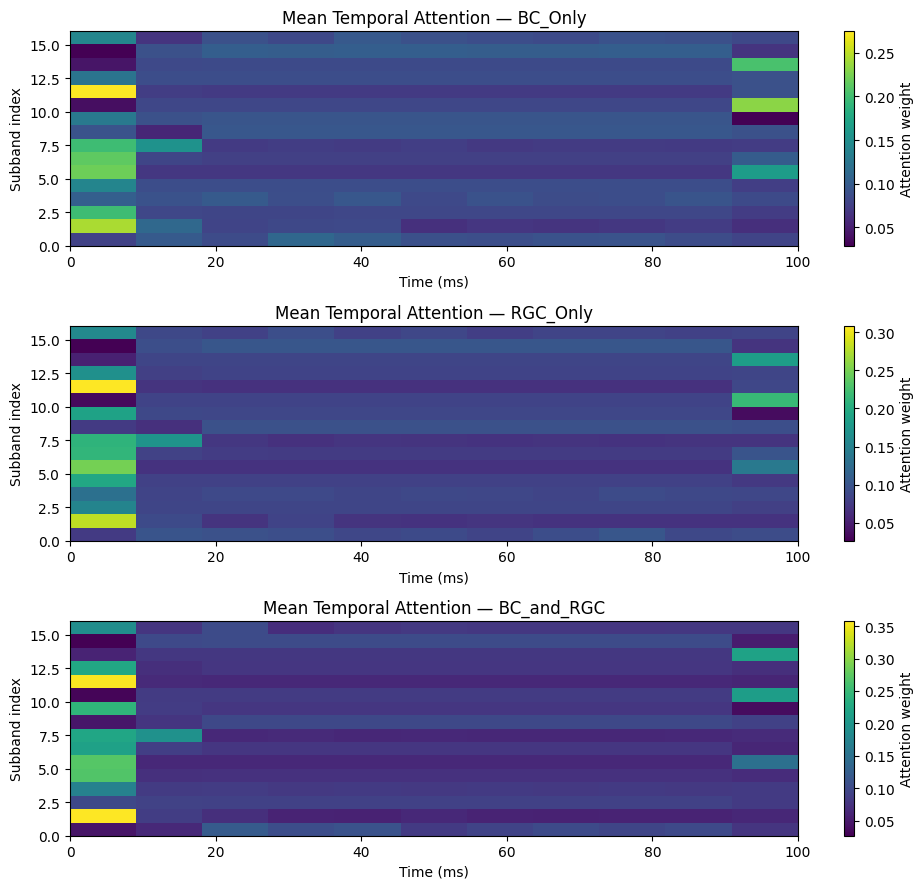

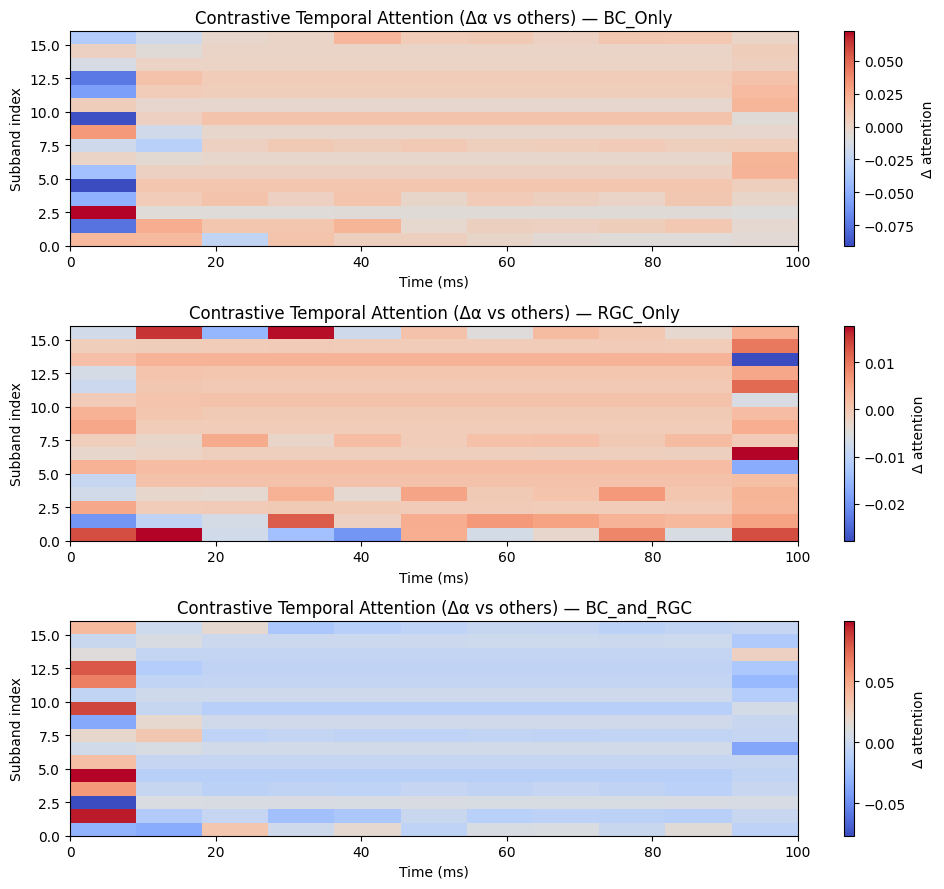

In [ ]:
# ---------------------------------------------------------------------
# 1. Prepare metadata and containers
# ---------------------------------------------------------------------

N_BRANCHES = len(temporal_att_maps)              # should equal 2**LEVEL = 16
TIME_STEPS = next(iter(temporal_att_maps.values())).shape[1]
T_MAX = 100  # ms (already defined)
time_axis = np.linspace(0, T_MAX, TIME_STEPS)

mean_temp_att_per_class = {cls: [] for cls in label_encoder.keys()}
contrast_temp_att_per_class = {cls: [] for cls in label_encoder.keys()}

# ---------------------------------------------------------------------
# 2. Compute mean and contrastive temporal attention
# ---------------------------------------------------------------------

for branch_idx in range(N_BRANCHES):
    att = temporal_att_maps[f"temporal_attention_{branch_idx}"].squeeze(-1)  # (n_samples, time_steps)

    for class_label, class_idx in label_encoder.items():
        mask = (y == class_idx)
        att_class = att[mask]                          # (n_class_samples, time_steps)
        att_other = att[~mask]

        mean_class = att_class.mean(axis=0)
        mean_other = att_other.mean(axis=0)
        contrast = mean_class - mean_other

        # Store per-class results per subband
        mean_temp_att_per_class[class_label].append(mean_class)
        contrast_temp_att_per_class[class_label].append(contrast)

# Convert lists to arrays: shape (n_classes, n_branches, time_steps)
for cls in label_encoder.keys():
    mean_temp_att_per_class[cls] = np.stack(mean_temp_att_per_class[cls])      # (n_branches, time_steps)
    contrast_temp_att_per_class[cls] = np.stack(contrast_temp_att_per_class[cls])


top_k = 5

for class_label in label_encoder.keys():
    print(f"\n=== Class: {class_label} ===")

    mean_branch = mean_temp_att_per_class[class_label]
    contrast_branch = contrast_temp_att_per_class[class_label]

    for b_idx in range(N_BRANCHES):
        mean_curve = mean_branch[b_idx]
        contrast_curve = contrast_branch[b_idx]

        # Top K timepoints with highest attention
        top_idx = np.argsort(mean_curve)[::-1][:top_k]

        print(f"  Subband {b_idx:2d}: Top {top_k} timepoints:")
        for i in top_idx:
            print(f"     t = {time_axis[i]:6.1f} ms | α={mean_curve[i]:.4f} | Δα={contrast_curve[i]:+.4f}")
    print("-" * 70)

n_classes = len(label_encoder)
fig, axes = plt.subplots(n_classes, 1, figsize=(10, 3*n_classes))

if n_classes == 1:
    axes = [axes]

for ax, (class_label, mean_att) in zip(axes, mean_temp_att_per_class.items()):
    im = ax.imshow(mean_att, aspect='auto', cmap='viridis',
                   extent=[time_axis[0], time_axis[-1], 0, N_BRANCHES],
                   origin='lower')
    ax.set_title(f"Mean Temporal Attention — {class_label}")
    ax.set_ylabel("Subband index")
    ax.set_xlabel("Time (ms)")
    plt.colorbar(im, ax=ax, label="Attention weight")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_classes, 1, figsize=(10, 3*n_classes))
if n_classes == 1:
    axes = [axes]

for ax, (class_label, contrast_att) in zip(axes, contrast_temp_att_per_class.items()):
    im = ax.imshow(contrast_att, aspect='auto', cmap='coolwarm',
                   extent=[time_axis[0], time_axis[-1], 0, N_BRANCHES],
                   origin='lower')
    ax.set_title(f"Contrastive Temporal Attention (Δα vs others) — {class_label}")
    ax.set_ylabel("Subband index")
    ax.set_xlabel("Time (ms)")
    plt.colorbar(im, ax=ax, label="Δ attention")

plt.tight_layout()
plt.show()


### Other code

NameError: name 'mean_att_per_class' is not defined

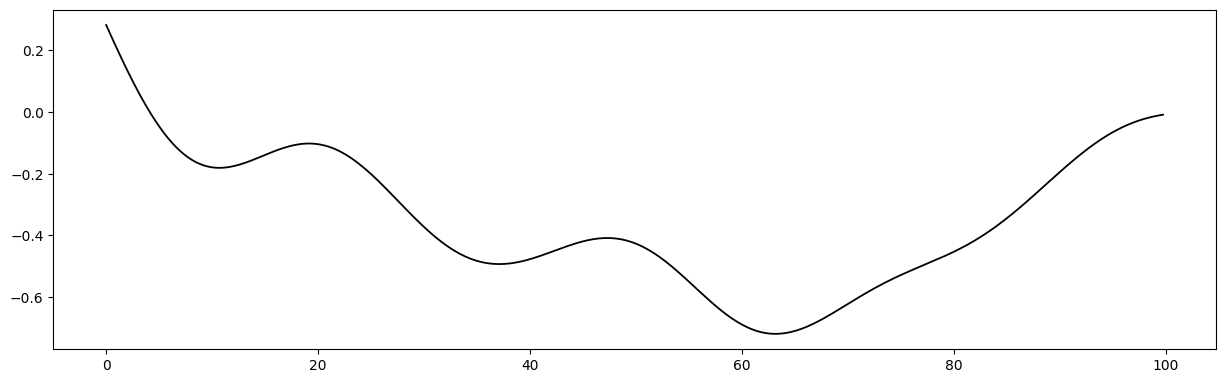

In [ ]:

def reconstruct_signal_from_subbands(signal, selected_indices, wavelet='db4', level=4):
    """
    Reconstructs the original signal using only a subset of WPD subbands.
    """
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
    nodes = wp.get_level(level, order='freq')
    for i, node in enumerate(nodes):
        if i not in selected_indices:
            wp[node.path].data = np.zeros_like(wp[node.path].data)
    return wp.reconstruct(update=False)

# ---------------------------------------------------------------------
# 6. Reconstruct and visualize example signals
# ---------------------------------------------------------------------

plt.figure(figsize=(15, 5 * len(label_encoder)))
k_bands_list = [3, 6, 9, 12]

for i, (class_label, class_idx) in enumerate(label_encoder.items()):
    example_idx = np.where(y == class_idx)[0][0]

    if class_label == "BC_Only": 
        file_list = sampled_BC
    elif class_label == "RGC_Only": 
        file_list = sampled_RGC
    else: 
        file_list = sampled_BC_and_RGC

    example_file = file_list[0]
    _, raw_signal = load_vep_csv(example_file, t_min=5, t_max=T_MAX)
    time_vector = np.linspace(0, T_MAX, len(raw_signal), endpoint=False)

    plt.subplot(len(label_encoder), 1, i + 1)
    plt.plot(time_vector, raw_signal, label="Raw Signal", color="black", linewidth=1.3)

    mean_weights = mean_att_per_class[class_label]
    for k in k_bands_list:
        top_idx = np.argsort(mean_weights)[::-1][:k]
        recon = reconstruct_signal_from_subbands(raw_signal, top_idx, WAVELET, LEVEL)
        plt.plot(time_vector, recon, linestyle="--", label=f"Top {k}/{N_BRANCHES} bands")

    plt.title(f"Signal reconstruction — {class_label}")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (a.u.)")
    plt.legend()

plt.tight_layout()
plt.show()




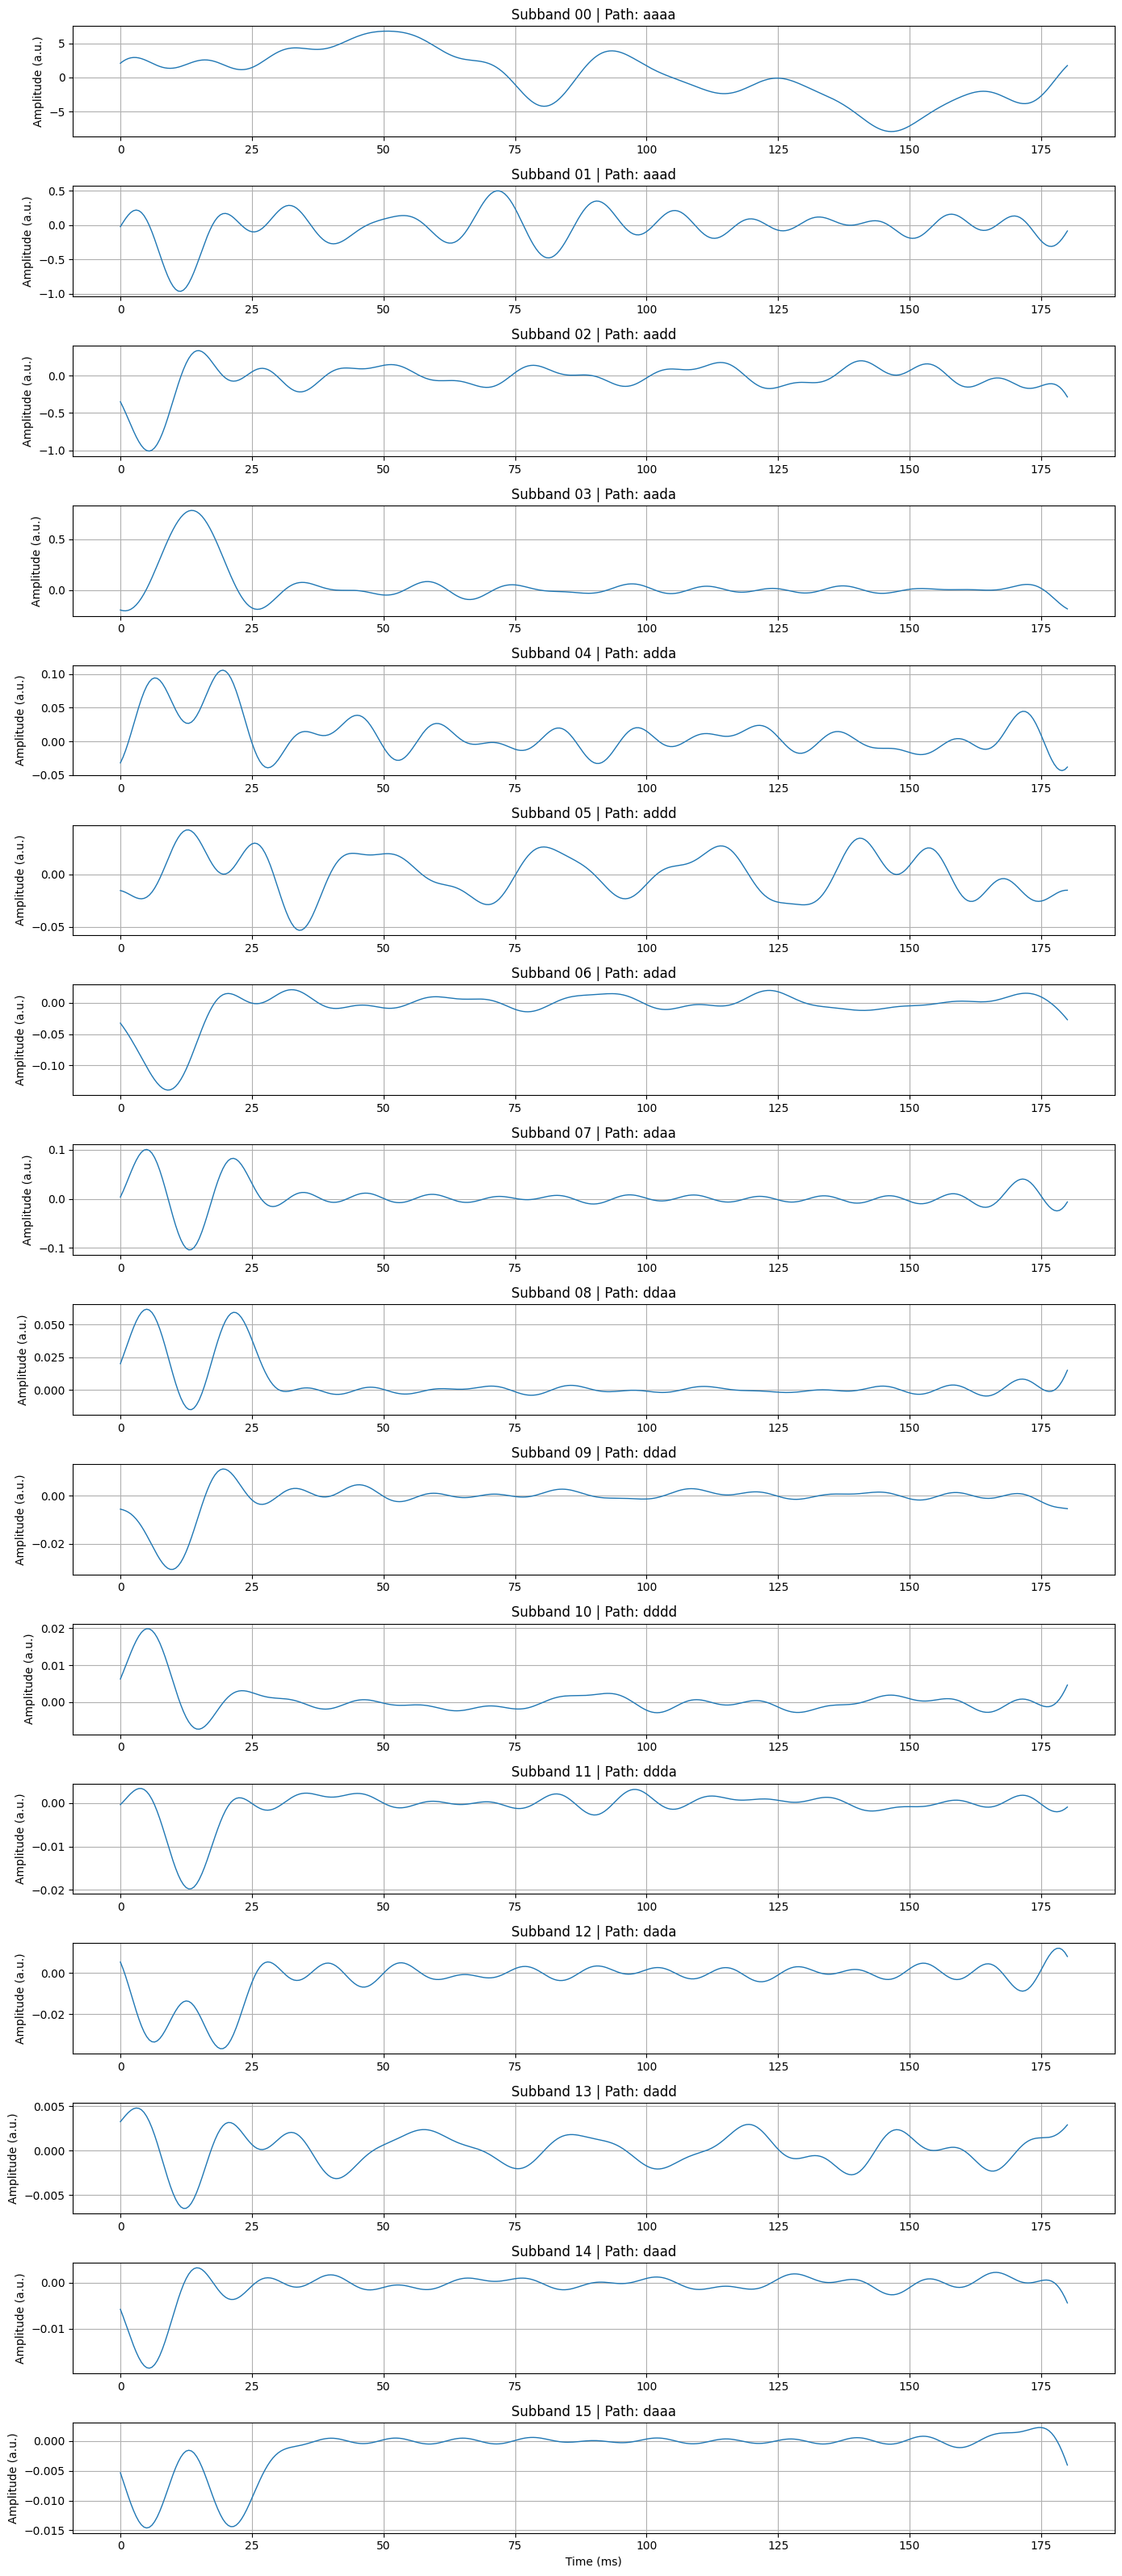

In [ ]:
from scipy.signal import resample

def plot_wpd_subbands(signal, wavelet='db4', level=4, sampling_rate=1000, resample_to_original=True):
    """
    Decomposes the signal using WPD and plots reconstructed waveforms of each subband.
    Automatically aligns lengths for plotting.

    Args:
        signal: 1D numpy array (raw signal)
        wavelet: str, wavelet name (e.g., 'db4')
        level: int, decomposition level
        sampling_rate: float, in Hz
        resample_to_original: bool, whether to resample each subband to signal length
    """
    wp = pywt.WaveletPacket(data=signal, wavelet=wavelet, mode='symmetric', maxlevel=level)
    nodes = wp.get_level(level, order='freq')
    n_bands = len(nodes)

    time_full = np.arange(len(signal)) / sampling_rate * 1000  # ms

    plt.figure(figsize=(14, 2 * n_bands))
    for i, node in enumerate(nodes):
        subband_sig = node.reconstruct(update=False)

        # Resample each subband to match original signal length (for aligned plotting)
        if resample_to_original:
            subband_sig = resample(subband_sig, len(signal))
            time_vector = time_full
        else:
            time_vector = np.arange(len(subband_sig)) / sampling_rate * 1000

        plt.subplot(n_bands, 1, i + 1)
        plt.plot(time_vector, subband_sig, linewidth=1)
        plt.title(f"Subband {i:02d} | Path: {node.path}")
        plt.ylabel("Amplitude (a.u.)")
        if i == n_bands - 1:
            plt.xlabel("Time (ms)")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage of plot_wpd_subbands
example_idx = np.where(y == label_encoder['BC_Only'])[0][0]
_, raw_signal = load_vep_csv(sampled_BC[0], t_min=5, t_max=100)
plot_wpd_subbands(raw_signal, wavelet='db4', level=4, sampling_rate=2000)